In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame

from numpy import dstack

import copy

import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Model

from keras.layers import Bidirectional

from keras.layers.merge import concatenate

from keras.utils.vis_utils import plot_model

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import keras.backend as K

import random

from sklearn.model_selection import train_test_split

from matplotlib import pyplot

## Load Data

In [2]:
from helpers.classes.data_loader import DataLoader

In [3]:
root_path = "/Users/allarviinamae/EduWorkspace/openpose-jupyter-data-exploration/centered-keypoints"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

samples = DataLoader.get_samples_list(sample_dir_names, root_path)

y_labels = DataLoader.get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

In [4]:
i = 5

# Print some sample dir names
a = [print(sample_dir_name) for sdn_i, sample_dir_name in enumerate(sample_dir_names) if sdn_i < i]
a = [print(y_label) for y_i, y_label in enumerate(y_labels) if y_i < i]

backflip-40-margus
flack-31-rasmus
flack-19-rasmus
flack-59-martin
backflip-66-allar
0
1
1
1
0


## Data padding

In [5]:
from helpers.classes.padder import Padder

In [6]:
padded_samples_list = Padder.get_padded_samples(samples)
categorical_y_labels = DataLoader.get_categorical_y_labels(y_labels)

padded_samples_ndarray = np.asarray(padded_samples_list)
categorical_y_labels_ndarray = np.asarray(categorical_y_labels)

y_labels_stacked shape: (1, 1, 113)
y_labels_categorical shape: (1, 1, 113, 2)
y_labels_squeezed shape (113, 2)
y_label categorical: [1.0, 0.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [0.0, 1.0]
y_label categorical: [1.0, 0.0]


## Split data

In [7]:
r_arm_keypoints = [2, 3, 4]
l_arm_keypoints = [5, 6, 7]
trunk_keypoints = [0, 1, 8]
r_leg_keypoints = [9, 10, 11]
l_leg_keypoints = [12, 13, 14]

def get_xy_keypoints(keypoints, max_keypoints=30):
    to_add = max_keypoints / 2
    
    xy_pairs = [(kp, int(kp + to_add)) for kp in keypoints]
    
    xy_keypoints = [item for sublist in xy_pairs for item in sublist] # flatten
    
    return xy_keypoints
    
def get_bodypart_padded_samples_ndarray(padded_samples_ndarray, keypoints):
    xy_keypoints = get_xy_keypoints(r_arm_keypoints)
        
    return padded_samples_ndarray[:, :, xy_keypoints]
    
r_arm_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, r_arm_keypoints)
l_arm_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, l_arm_keypoints)
trunk_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, trunk_keypoints)
r_leg_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, r_leg_keypoints)
l_leg_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, l_leg_keypoints)

In [119]:
r_arm_X_train, r_arm_X_test, y_train, y_test = train_test_split(r_arm_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

l_arm_X_train, l_arm_X_test, y_train, y_test = train_test_split(l_arm_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

trunk_X_train, trunk_X_test, y_train, y_test = train_test_split(trunk_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

r_leg_X_train, r_leg_X_test, y_train, y_test = train_test_split(r_leg_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

l_leg_X_train, l_leg_X_test, y_train, y_test = train_test_split(l_leg_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)


print(f"trunk_X_train shape: {trunk_X_train.shape}")
print(f"X train len: {len(trunk_X_train)}, y train len:{len(y_train)} --- X test len:{len(trunk_X_test)}, y test len:{len(y_test)}")

trunk_X_train shape: (90, 110, 6)
X train len: 90, y train len:90 --- X test len:23, y test len:23


## Build model

In [212]:
def get_simple_rnn_model(lstm_units, n_outputs, n_features, n_timesteps):
    optimizer = Adam(lr=0.001)
    
    input_shape = (n_timesteps, n_features)
    print(f"Model input shape {input_shape}")
    
    # R arm
    model1_in = Input(shape=input_shape)
    r_arm_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="r_arm_layer")(model1_in)

    # L arm
    model2_in = Input(shape=input_shape)
    l_arm_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="l_arm_layer")(model2_in)
    
    # trunk
    model3_in = Input(shape=input_shape)
    trunk_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="trunk_layer")(model3_in)
    
    # R leg
    model4_in = Input(shape=input_shape)
    r_leg_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="r_leg_layer")(model4_in)
    
    # L leg
    model5_in = Input(shape=input_shape)
    l_leg_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="l_leg_layer")(model5_in)
    
    # First merge layer
    r_arm_trunk_layer = concatenate([r_arm_out, trunk_out], name="r_arm_trunk_layer")
    
    l_arm_trunk_layer = concatenate([l_arm_out, trunk_out], name="l_arm_trunk_layer")
    
    r_leg_trunk_layer = concatenate([r_leg_out, trunk_out], name="r_leg_trunk_layer")
    
    l_leg_trunk_layer = concatenate([l_leg_out, trunk_out], name="l_leg_trunk_layer")
    
    # Second merge layer
    
    upper_body_layer = concatenate([r_arm_trunk_layer, l_arm_trunk_layer], name="upper_body_layer")
    
    lower_body_layer = concatenate([r_leg_trunk_layer, l_leg_trunk_layer], name="lower_body_layer")
    
    # Third merge layer
    
    full_body_layer = concatenate([upper_body_layer, lower_body_layer], name="full_body_layer")
    
    dropout_layer = Dropout(0.5)(full_body_layer)
    
    activation_layer = Dense(lstm_units, activation='relu', name="relu_layer")(dropout_layer)
    
    flatten_layer = Flatten()(activation_layer)
        
    output_layer = Dense(n_outputs, activation='softmax', name="softmax_layer")(flatten_layer)

    model = Model([model1_in, model2_in, model3_in, model4_in, model5_in], output_layer)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def evaluate_model(trainXs, trainy, testXs, testy):
    verbose, epochs = 1, 5
    
    #n_steps_per_epoch = 360
    
    lstm_units = 2

    n_timesteps, n_features, n_outputs = trainXs[0].shape[1], trainXs[0].shape[2], trainy.shape[1]
    
    model = get_simple_rnn_model(lstm_units, n_outputs, n_features, n_timesteps)
    
    print(model.summary())
    
    batch_size = 1
    
    es_callback = EarlyStopping(monitor='val_loss',
                                patience=3)
    
    history = model.fit(trainXs,
                        trainy,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_split=0.33,
                        #callbacks=[es_callback]
                       )
    # evaluate model
    _, accuracy = model.evaluate(testXs, testy, batch_size=batch_size, verbose=0)
    
    # fit network
    #model.fit_generator(train_generator(trainX, trainy), steps_per_epoch=n_steps_per_epoch, epochs=epochs, verbose=verbose)
    # evaluate model
    #_, accuracy = model.evaluate_generator(train_generator(testX, testy), steps=len(testX), verbose=0)
    
    return history, accuracy, model

In [213]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [214]:
def save_model(model, repeat):
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"model-{repeat}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"model-{repeat}.h5")
    
    plot_model(model, to_file=f"model-plot-{repeat}.png", show_shapes=True, show_layer_names=True)
    
    print("Saved model to disk")

## Run experiment

In [215]:
train_loss_history = DataFrame()
val_loss_history = DataFrame()

train_accuracy_history = DataFrame()
val_accuracy_history = DataFrame()

model_history = []

# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    last_history = None
    
    for r in range(repeats):
        history, score, model = evaluate_model([r_arm_X_train, l_arm_X_train, trunk_X_train, r_leg_X_train, l_leg_X_train],
                                               y_train,
                                               [r_arm_X_test, l_arm_X_test, trunk_X_test, r_leg_X_test, l_leg_X_test],
                                               y_test)
        
        model_history.append(model)
        save_model(model, r)
        
        # story history
        train_loss_history[str(r)] = history.history['loss']
        val_loss_history[str(r)] = history.history['val_loss']
        train_accuracy_history[str(r)] = history.history['accuracy']
        val_accuracy_history[str(r)] = history.history['val_accuracy']
        
        score = score * 100.0
        print('>#%d validation accuracy: %.3f' % (r+1, score))
        scores.append(score)
        
    # summarize results
    summarize_results(scores)
    
run_experiment()

Model input shape (110, 6)
Model: "model_106"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_263 (InputLayer)          (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_265 (InputLayer)          (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_264 (InputLayer)          (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_266 (InputLayer)          (None, 110, 6)       0                                            
_______________________________________________________________

Train on 60 samples, validate on 30 samples
Epoch 1/5
60/60 [==============================] - 5s 90ms/step - loss: 0.8762 - accuracy: 0.6167 - val_loss: 0.2972 - val_accuracy: 0.9000
Epoch 2/5
60/60 [==============================] - 5s 78ms/step - loss: 0.7347 - accuracy: 0.6500 - val_loss: 0.1847 - val_accuracy: 0.9667
Epoch 3/5
60/60 [==============================] - 4s 70ms/step - loss: 0.4351 - accuracy: 0.8000 - val_loss: 0.1307 - val_accuracy: 0.9667
Epoch 4/5
60/60 [==============================] - 3s 51ms/step - loss: 0.2155 - accuracy: 0.9167 - val_loss: 0.0775 - val_accuracy: 0.9667
Epoch 5/5
60/60 [==============================] - 3s 53ms/step - loss: 0.1369 - accuracy: 0.9667 - val_loss: 0.0634 - val_accuracy: 0.9667
Saved model to disk
>#2 validation accuracy: 91.304
Model input shape (110, 6)
Model: "model_108"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param 

Train on 60 samples, validate on 30 samples
Epoch 1/5
60/60 [==============================] - 5s 89ms/step - loss: 1.0232 - accuracy: 0.5667 - val_loss: 0.5640 - val_accuracy: 0.7333
Epoch 2/5
60/60 [==============================] - 4s 61ms/step - loss: 0.7432 - accuracy: 0.7000 - val_loss: 0.4158 - val_accuracy: 0.8333
Epoch 3/5
60/60 [==============================] - 3s 54ms/step - loss: 0.4829 - accuracy: 0.7333 - val_loss: 0.2543 - val_accuracy: 0.9333
Epoch 4/5
60/60 [==============================] - 3s 57ms/step - loss: 0.2462 - accuracy: 0.9000 - val_loss: 0.1241 - val_accuracy: 0.9667
Epoch 5/5
60/60 [==============================] - 4s 61ms/step - loss: 0.1769 - accuracy: 0.9667 - val_loss: 0.0627 - val_accuracy: 1.0000
Saved model to disk
>#4 validation accuracy: 100.000
Model input shape (110, 6)
Model: "model_110"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param

## Plots

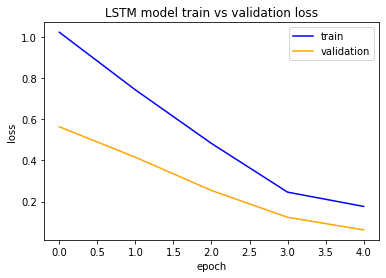

In [216]:
pyplot.plot(train_loss_history['3'], color='blue', label='train')
pyplot.plot(val_loss_history['3'], color='orange', label='validation')
pyplot.title('LSTM model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

pyplot.savefig('model-train-vs-validation-loss.png')

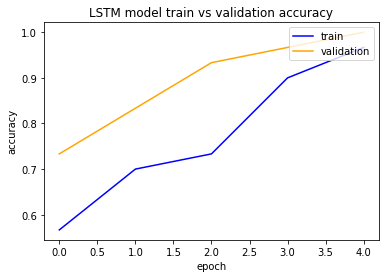

In [217]:
pyplot.plot(train_accuracy_history['3'], color='blue', label='train')
pyplot.plot(val_accuracy_history['3'], color='orange', label='validation')
pyplot.title('LSTM model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

pyplot.savefig('model-train-vs-validation-accuracy.png')

## Sample

In [168]:
example_sample_idx = 40
model_history_idx = 4

#example_sample_dir_name = sample_dir_names[example_sample_idx]
example_sample = r_arm_X_train[example_sample_idx]
example_model = model_history[model_history_idx]

## Predictions

In [170]:
def predictions(loaded_model, samples, sample_dir_names, y_labels):
    ynew = loaded_model.predict(samples)
        
    ynew = np.argmax(ynew,axis=1)
    y_labels = np.argmax(y_labels,axis=1)
    
    print(ynew)

    # show the inputs and predicted outputs
    for i in range(len(samples[0])):
        pred_y = ynew[i]
        actual_y = y_labels[i]
    
        same = False
        if pred_y == actual_y:
            same = True
    
        print("Name=%s, X=%s, Predicted=%s, Actual=%s, same=%s" % (sample_dir_names[i], i, pred_y, actual_y, same))
    
predictions(example_model, [r_arm_X_test, l_arm_X_test, trunk_X_test, r_leg_X_test, l_leg_X_test], sample_dir_names, y_test)

[1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0]
Name=backflip-40-margus, X=0, Predicted=1, Actual=1, same=True
Name=flack-31-rasmus, X=1, Predicted=0, Actual=0, same=True
Name=flack-19-rasmus, X=2, Predicted=1, Actual=1, same=True
Name=flack-59-martin, X=3, Predicted=0, Actual=0, same=True
Name=backflip-66-allar, X=4, Predicted=1, Actual=1, same=True
Name=flack-55-martin, X=5, Predicted=0, Actual=0, same=True
Name=flack-68-rasmus, X=6, Predicted=1, Actual=1, same=True
Name=backflip-23-tiit, X=7, Predicted=1, Actual=1, same=True
Name=flack-7-hendrik, X=8, Predicted=1, Actual=0, same=False
Name=flack-4-martin, X=9, Predicted=1, Actual=1, same=True
Name=flack-15-rasmus, X=10, Predicted=0, Actual=0, same=True
Name=flack-36-hendrik, X=11, Predicted=1, Actual=1, same=True
Name=backflip-64-allar, X=12, Predicted=0, Actual=0, same=True
Name=backflip-6-rasmus, X=13, Predicted=0, Actual=0, same=True
Name=flack-82-martin, X=14, Predicted=0, Actual=0, same=True
Name=flack-35-margus, X=15, Predicte

## Activation

In [171]:
layer_names = [layer.name for layer in example_model.layers]

print(example_sample.shape)
print(layer_names)

def activations(model, example_sample): 
    n_timesteps, n_features = example_sample.shape[0], example_sample.shape[1]
    
    print(f"n_timesteps: {n_timesteps}, n_features: {n_features}")
    
    x = np.zeros((1, n_timesteps, n_features))
    
    for t, timestep in enumerate(example_sample):
        for f, feature in enumerate(timestep):
            x[0, t, f] = example_sample[t][f]
                
    output = model.get_layer('r_arm_layer').output
    
    f = K.function([model.input[0]], [output])
    
    f_result = f([x])
    
    return f_result[0][0]


act = activations(example_model, example_sample)
print(act)
act.shape

(110, 6)
['input_123', 'input_124', 'input_125', 'input_126', 'input_127', 'r_arm_layer', 'l_arm_layer', 'trunk_layer', 'r_leg_layer', 'l_leg_layer', 'concatenate_60', 'dropout_41', 'dense_105', 'flatten_48', 'dense_106']
n_timesteps: 110, n_features: 6
[[ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.         -0.92070866]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.          0.9762288 ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.

(110, 2)

In [172]:
from io import BytesIO
from PIL import Image as PILImage
from PIL import ImageDraw
from IPython.display import Image

def get_image(img, n_timesteps, img_idx, cell_size=48):
    img_width = n_timesteps * 25
    cell_size = int(img_width / n_timesteps)
    
    pil_image = PILImage.fromarray(img.astype(np.uint8))
    
    resized_pil_image = pil_image.resize((img_width, cell_size))
    #resized_pil_image = pil_image
    
    draw = ImageDraw.Draw(resized_pil_image)
    
    for n_timestep in range(n_timesteps):
        text = str((img_idx * 30) + n_timestep)
        xy = (n_timestep * cell_size, 0)
        
        draw.text(xy, text)
        
    f = BytesIO()
    resized_pil_image.save(f, 'png')
    return Image(data=f.getvalue())

def visualize_neurons(act, cell_size=48):
    n_neurons = act.shape[1]
    n_timesteps = act.shape[0]
    
    fill_value = 128
    
    img = np.full((n_neurons + 1, n_timesteps, 3), fill_value)
    
    # add 1 to each value in matrix and then divide by 2
    scores = (act[:, :].T + 1) / 2
    
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores

    first_hs_img = img[:, :30, :]
    second_hs_img = img[:, 30:60, :]
    third_hs_img = img[:, 60:90, :]
    fourth_hs_img = img[:, 90:, :]
    
    imgs = [first_hs_img,
            second_hs_img,
            third_hs_img,
            fourth_hs_img]
    
    actual_imgs = []
    for i, img in enumerate(imgs):
        n_img_timesteps = img.shape[1]
        
        actual_imgs.append(get_image(img, n_img_timesteps, i))
    
    return actual_imgs

example_sample_imgs = visualize_neurons(act)

for img in example_sample_imgs:
    display(img)